<a href="https://colab.research.google.com/github/everestso/Summer24/blob/main/EmnistSavedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets

import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import time

100%|██████████| 561753746/561753746 [00:07<00:00, 71339577.93it/s] 


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw
Number of training samples: 112800
Number of testing samples: 18800


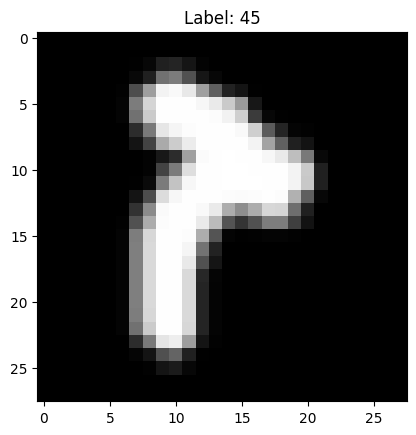

In [2]:
# Assuming train_dataset and test_dataset are lists of (image, label) tuples
# where image is a PIL Image

# Define a transform to convert PIL Image to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean 0.5 and std 0.5 for grayscale images
])

# Load the EMNIST dataset
train_dataset = datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_dataset = datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)

# Get the training and testing data and labels
images, labels = train_dataset.data, train_dataset.targets
test_images, test_labels = test_dataset.data, test_dataset.targets

# Display basic information about the dataset
print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of testing samples: {len(test_dataset)}')

# Show a sample image


# Display the first image in the batch
plt.imshow(images[0].numpy().squeeze(), cmap='gray')
plt.title(f'Label: {labels[0]}')
plt.show()

In [3]:
# Create a dictionary mapping integers to characters
map_dict = {0: '0',  1: '1', 2: '2', 3: '3', 4: '4', 5: '5',
            6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B',
            12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H',
            18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N',
            24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
            30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z',
            36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g',
            42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}

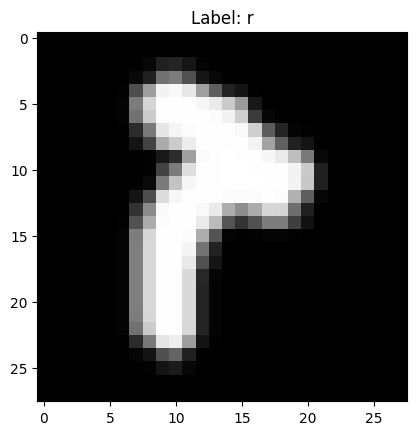

In [4]:
# Display the first image in the batch
plt.imshow(images[0].numpy().squeeze(), cmap='gray')
plt.title(f'Label: {map_dict[int(labels[0])]}')
plt.show()

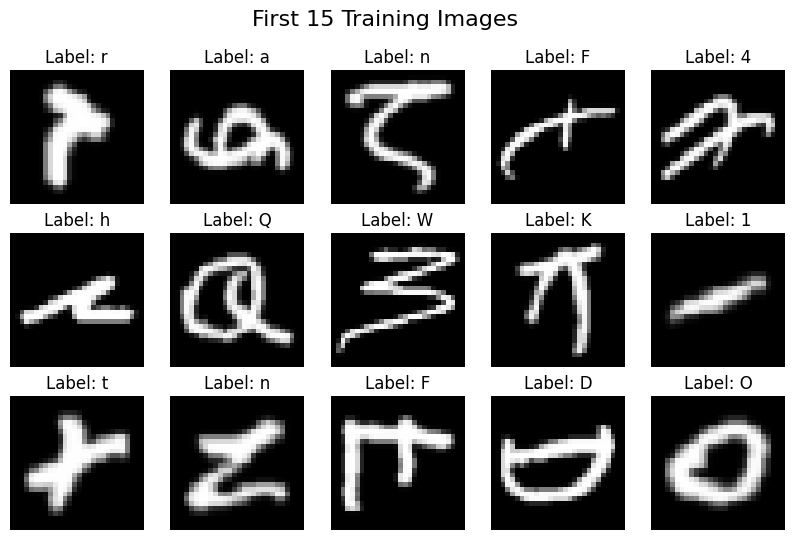

In [5]:
# prompt: generate a 3 x 5 plot of the first 15 training items.

import matplotlib.pyplot as plt

# Plot the first 15 training images
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].numpy().squeeze(), cmap='gray')
    ax.set_title(f'Label: {map_dict[int(labels[i])]}')
    ax.axis('off')

plt.suptitle('First 15 Training Images', fontsize=16)
plt.show()

In [7]:
from torch.utils.data import DataLoader
loaders = {
    'test'  : torch.utils.data.DataLoader(test_dataset,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),
}
loaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x795823142470>}

# Define Model

In [27]:
import torch.nn as nn

number_of_classes = 47

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output number_of_classes classes
        self.out = nn.Linear(32 * 7 * 7, number_of_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization

In [24]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        accuracies = []
        for images, labels in loaders['test']:
            images = images.to(device)
            labels = labels.to(device)
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            accuracy = round(accuracy,2)
            accuracies.append(accuracy)
        return accuracies

# Mount Google Drive

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Restore Model & Test

In [28]:
model_load_path = '/content/drive/My Drive/my_First_model_10epochs.pth'
#model_load_path = '/content/drive/My Drive/my_First_model_30epochs.pth'

overwrite = input("{model_load_path}: Warning: About to Load. Continue? (y/n): ")
if overwrite.lower() != 'y':
  print("Overwrite aborted.")
else:
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  loaded_model = CNN().to(device)  # Assuming 'device' is defined as before
  cnn = loaded_model
  cnn.load_state_dict(torch.load(model_load_path, map_location=device))

{model_load_path}: Warning: About to Load. Continue? (y/n): y


In [29]:
# Test restored model
accuracies = test()

In [22]:
print(f'Test Accuracy of the model test images: {accuracies}')
print('Average Accuracy of the model test images: %.2f' % np.average(accuracies))

Test Accuracy of the model test images: [0.89, 0.88, 0.85, 0.82, 0.85, 0.84, 0.82, 0.86, 0.86, 0.85, 0.85, 0.86, 0.87, 0.88, 0.87, 0.84, 0.84, 0.85, 0.84, 0.85, 0.89, 0.85, 0.83, 0.75, 0.86, 0.83, 0.86, 0.91, 0.91, 0.89, 0.89, 0.76, 0.81, 0.88, 0.83, 0.81, 0.85, 0.83, 0.86, 0.88, 0.78, 0.88, 0.88, 0.88, 0.79, 0.85, 0.8, 0.87, 0.79, 0.82, 0.82, 0.84, 0.9, 0.79, 0.89, 0.83, 0.85, 0.8, 0.82, 0.85, 0.86, 0.89, 0.79, 0.85, 0.89, 0.9, 0.84, 0.88, 0.88, 0.87, 0.83, 0.86, 0.8, 0.85, 0.83, 0.85, 0.83, 0.86, 0.83, 0.89, 0.85, 0.83, 0.82, 0.83, 0.84, 0.82, 0.84, 0.86, 0.84, 0.79, 0.88, 0.86, 0.84, 0.82, 0.84, 0.8, 0.83, 0.86, 0.82, 0.82, 0.83, 0.79, 0.86, 0.85, 0.84, 0.86, 0.79, 0.85, 0.82, 0.83, 0.85, 0.88, 0.88, 0.82, 0.73, 0.84, 0.83, 0.84, 0.89, 0.85, 0.84, 0.86, 0.8, 0.89, 0.9, 0.83, 0.81, 0.81, 0.82, 0.81, 0.86, 0.85, 0.81, 0.84, 0.89, 0.84, 0.87, 0.81, 0.85, 0.82, 0.87, 0.85, 0.87, 0.86, 0.82, 0.84, 0.84, 0.83, 0.85, 0.81, 0.84, 0.79, 0.88, 0.85, 0.87, 0.87, 0.81, 0.91, 0.78, 0.87, 0.82, 0